## A comparative analysis of the 3 tabular methods of Reinforcement Learning
* Dynamic Programming (DP)
* Monte Carlo (MC)
* Temporal Difference (TD), particularly, TD(0): one step TD

In [4]:
# Pre-req package install commands. Uncomment if you are thrown a "ModuleNotFoundError"
#!pip install numpy
#!pip install tqdm
#!pip install matplotlib
#!pip install seaborn

In [2]:

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%pylab inline
import random

Populating the interactive namespace from numpy and matplotlib


/Users/ashis/venv-DP+MC+TD/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## The GridWorld
![gridword](figs/DP-01.png)
* robot must move through the grid to end up in a termination state (grey squares).
* Each grid square is a state.
* The actions that can be taken are up, down, left or right and we assume that these actions are deterministic, meaning every time that the robot picks the option to go up, the robot will go up.

## The GridWorld
![gridword](figs/DP-01.png)
* robot must move through the grid to end up in a termination state (grey squares).
* Each grid square is a state.
* The actions that can be taken are up, down, left or right and we assume that these actions are deterministic, meaning every time that the robot picks the option to go up, the robot will go up.
* There’s an exception, which is when the robot hits the wall. In this case, the final state is the same as the initial state (cannot break the wall).
* for every move or attempt against the wall, a reward of -1 will be given except if the robot reaches the terminal state, in which case the reward will be 0. And the game ends.

![gridword](figs/DP-01.png)
* there are different ways the robot could pick an action. These rules based on which the robot picks an action is what is called the policy.
* In the simplest of cases, imagine the robot would move to every direction with the same probability, i.e. there is 25% probability it moves to top, 25% to left, 25% to bottom and 25% to right. Let’s call this the random policy. Following this random policy, the question is: what’s the value or how good it is for the robot to be in each of the gridworld states/squares?

# Dynamic Programming : Policy Evaluation
* The key of the algorithm is the assignment to $V(s)$
![Policy-iteration](figs/DP-02.png)

# Dynamic Programming : Policy Evaluation
* The key of the algorithm is the assignment to $V(s)$
![Policy-iteration](figs/DP-03.png)

# Dynamic Programming : Policy Evaluation
* The key of the algorithm is the assignment to $V(s)$
![Policy-iteration](figs/DP-02.png)
* The idea is that we start with a value function that is an array of $4\times 4$ dimensions (as big as the grid) with zeroes. 
* Now we iterate for each state and we calculate its new value as the weighted sum of the reward (-1) plus the value of each neighbor states (s’). Note, $V(s')$ is the overlapping subproblem of the Dynamic programming setup.
* the V(s’) is the expected value of the final/neighbor state s’ (at the beginning the expected value is 0 as we initialize the value function with zeroes)
* the V(s’) is multiplied by a gamma, which is the discounting factor.
* we can repeat this process over and over in which we “sweep” and update the state-value function for all the states.
* These values can get iteratively updated until reaching convergence.
* In fact in the iterative policy evaluation algorithm, you can see we calculate some delta that reflect how much the value of a state changes respect the previous value.
* These deltas decay over the iterations and are supposed to reach 0 at the infinity.

# Dynamic Programming : Policy Evaluation
* The key of the algorithm is the assignment to $V(s)$
![Policy-iteration](figs/DP-04.png)

## Let's implement the DP

#### Parameters

In [21]:
gamma = 0.5 # discounting rate. Far-sighted=1, short-sighted=0
rewardSize = -1
gridSize = 4
terminationStates = [[0,0], [gridSize-1, gridSize-1]]  #(top,left) and (bottom,right) states

#a note on action space,
# say, you are at (r,c).
# First action: going up. You new position will be (r-1, c). 
#.              Therefore, the first action is [-1,0] to be added to your current position.
actions = [[-1, 0], #going up
           [1, 0], #going down
           [0, 1], #going right
           [0, -1] #going left
          ]
numIterations = 1000

# choose an action and update randomly 
policy = {}
for sx in range(gridSize): #if you are in state, s what should you do?
    for sy in range(gridSize):
        s = str([sx,sy])
        #print(s)
        policy[s] = np.random.choice(len(actions)) #random policy

In [4]:
def printPolicy(policy):
    #print policy
    for i in range(gridSize):
        for j in range(gridSize):
            s = str([i,j])
            action_idx = policy[s]
            a = actions[action_idx]

            if a[0]==-1 and a[1]==0:
                print('U',end='')
            elif a[0]==1 and a[1]==0:
                print('D',end='')
            elif a[0]==0 and a[1]==1:
                print('R',end='')
            elif a[0]==0 and a[1]==-1:
                print('L',end='')
        print()

In [5]:
printPolicy(policy)

LRDL
RRLD
RDLD
UDLU


#### Reward Function

In [6]:
def actionRewardFunction(initialPosition, action):
    
    if initialPosition in terminationStates:
        return initialPosition, 0
    
    reward = rewardSize
    finalPosition = np.array(initialPosition) + np.array(action)
    
    if -1 in finalPosition or 4 in finalPosition: #You can't break the wall
        finalPosition = initialPosition
        
    return finalPosition, reward

#### Initialization

In [22]:
V = np.zeros((gridSize, gridSize))
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
states

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [1, 0],
 [1, 1],
 [1, 2],
 [1, 3],
 [2, 0],
 [2, 1],
 [2, 2],
 [2, 3],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 3]]

In [9]:
# values of the value function at step 0
V

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Policy Evaluation

In [23]:
deltas = []
for it in range(numIterations):
    copyV = np.copy(V)
    deltaState = []
    
    for state in states:
        weightedRewards = 0
        for action in actions:
            finalPosition, reward = actionRewardFunction(state, action)
            weightedRewards += (1/len(actions))*(reward+(gamma*V[finalPosition[0], finalPosition[1]]))
        deltaState.append(np.abs(copyV[state[0], state[1]]-weightedRewards))
        copyV[state[0], state[1]] = weightedRewards
    deltas.append(deltaState)
    V = copyV
    
    if it in [0,1,2,9, 99, numIterations-1]:
        print("Iteration {}".format(it+1))
        print(V)
        print("")

Iteration 1
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]

Iteration 2
[[ 0.    -1.375 -1.5   -1.5  ]
 [-1.375 -1.5   -1.5   -1.5  ]
 [-1.5   -1.5   -1.5   -1.375]
 [-1.5   -1.5   -1.375  0.   ]]

Iteration 3
[[ 0.       -1.546875 -1.734375 -1.75    ]
 [-1.546875 -1.71875  -1.75     -1.734375]
 [-1.734375 -1.75     -1.71875  -1.546875]
 [-1.75     -1.734375 -1.546875  0.      ]]

Iteration 10
[[ 0.         -1.69413894 -1.94800401 -1.98176628]
 [-1.69413894 -1.91424173 -1.96495885 -1.94800401]
 [-1.94800401 -1.96495885 -1.91424173 -1.69413894]
 [-1.98176628 -1.94800401 -1.69413894  0.        ]]

Iteration 100
[[ 0.         -1.69491525 -1.94915254 -1.98305085]
 [-1.69491525 -1.91525424 -1.96610169 -1.94915254]
 [-1.94915254 -1.96610169 -1.91525424 -1.69491525]
 [-1.98305085 -1.94915254 -1.69491525  0.        ]]

Iteration 1000
[[ 0.         -1.69491525 -1.94915254 -1.98305085]
 [-1.69491525 -1.91525424 -1.96610169 -1.94915254]
 [-1.94915254 -1.96610169 -1.9

In [11]:
len(deltas) #Number of iterations

1000

In [30]:
len(deltas[0]) #we are talking about values of all the states

16

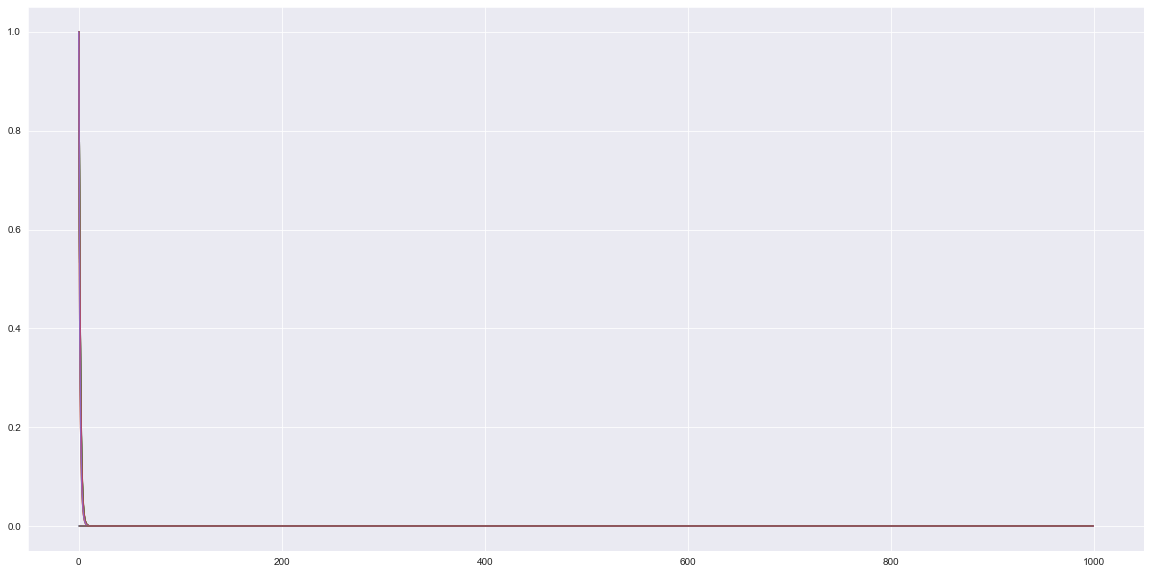

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(deltas) #Convergence of delta for each of the 16 states

# Monte Carlo
* While the Dynamic Programming approach assumes we have a complete knowledge of the environment, many times this is not the case.
* Monte Carlo (MC) methods are able to learn directly from experience or episodes rather than relying on the prior knowledge of the environment dynamics.
* The term “Monte Carlo” is often used broadly for any estimation method whose operation involves a significant random component.
* In many cases is possible to generate experiences sampled according to the desired probability distributions but infeasible to obtain the distributions in explicit form.

## Monte Carlo GridWorld
![mc](figs/MC-01.png)
* we can produce n simulations starting from random points of the grid, and let the robot move randomly to the four directions until a termination state is achieved. 
* For each simulation we save the 4 values: (1) the initial state, (2) the action taken, (3) the reward received and (4) the final state.
* In the end, a simulation is just an array containing x arrays of these values, x being the number of steps the robot had to take until reaching a terminal state.
* Now, from these simulations, we iterate from the end of the “experience” array, and compute G as the previous state value in the same experience (weighed by gamma, the discount factor) plus the received reward in that state. 
* We then store G in an array of Returns(St).
* Finally, for each state we compute the average of the Returns(St) and we set this as the state value at a particular iteration.

## Let's implement it

In [25]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%pylab inline
import random

Populating the interactive namespace from numpy and matplotlib


/Users/ashis/venv-DP+MC+TD/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gamma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### First-visit Monte Carlo

In [26]:
# parameters
gamma = 1 # discounting rate
rewardSize = -1
gridSize = 4
terminationStates = [[0,0], [gridSize-1, gridSize-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
numIterations = 10000

In [27]:
# initialization
V = np.zeros((gridSize, gridSize))
returns = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
deltas = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]

In [28]:
# Random sampling of a complete episode
def generateEpisode():
    initState = random.choice(states[1:-1])
    episode = []
    while True:
        if list(initState) in terminationStates:
            return episode
        action = random.choice(actions)
        finalState = np.array(initState)+np.array(action)
        if -1 in list(finalState) or gridSize in list(finalState):
            finalState = initState
        episode.append([list(initState), action, rewardSize, list(finalState)])
        initState = finalState

In [29]:
ep = generateEpisode() #let's try to generate an episode
# (1) the initial state, (2) the action taken, (3) the reward received and (4) the final state.
ep

[[[1, 0], [0, -1], -1, [1, 0]],
 [[1, 0], [0, 1], -1, [1, 1]],
 [[1, 1], [1, 0], -1, [2, 1]],
 [[2, 1], [1, 0], -1, [3, 1]],
 [[3, 1], [-1, 0], -1, [2, 1]],
 [[2, 1], [1, 0], -1, [3, 1]],
 [[3, 1], [0, -1], -1, [3, 0]],
 [[3, 0], [0, -1], -1, [3, 0]],
 [[3, 0], [0, 1], -1, [3, 1]],
 [[3, 1], [-1, 0], -1, [2, 1]],
 [[2, 1], [1, 0], -1, [3, 1]],
 [[3, 1], [0, 1], -1, [3, 2]],
 [[3, 2], [0, -1], -1, [3, 1]],
 [[3, 1], [0, -1], -1, [3, 0]],
 [[3, 0], [0, -1], -1, [3, 0]],
 [[3, 0], [1, 0], -1, [3, 0]],
 [[3, 0], [0, 1], -1, [3, 1]],
 [[3, 1], [1, 0], -1, [3, 1]],
 [[3, 1], [-1, 0], -1, [2, 1]],
 [[2, 1], [1, 0], -1, [3, 1]],
 [[3, 1], [0, -1], -1, [3, 0]],
 [[3, 0], [1, 0], -1, [3, 0]],
 [[3, 0], [-1, 0], -1, [2, 0]],
 [[2, 0], [-1, 0], -1, [1, 0]],
 [[1, 0], [0, 1], -1, [1, 1]],
 [[1, 1], [0, -1], -1, [1, 0]],
 [[1, 0], [-1, 0], -1, [0, 0]]]

In [94]:
for i, step in enumerate(ep):
    print(i)
    print(step)

0
[[1, 1], [0, -1], -1, [1, 0]]
1
[[1, 0], [1, 0], -1, [2, 0]]
2
[[2, 0], [-1, 0], -1, [1, 0]]
3
[[1, 0], [0, 1], -1, [1, 1]]
4
[[1, 1], [0, -1], -1, [1, 0]]
5
[[1, 0], [-1, 0], -1, [0, 0]]


In [30]:
for it in tqdm(range(numIterations)):
    episode = generateEpisode()
    G = 0
    #print(episode)
    for i, step in enumerate(episode):
        G = gamma*G + step[2]    #step[2]: Reward
        if step[0] not in [ x[0] for x in episode[len(episode)-i:]]: #not a terminal state
            idx = (step[0][0], step[0][1]) #step[0]: initial state
            returns[idx].append(G)
            newValue = np.average(returns[idx])
            
            deltas[idx[0], idx[1]].append(np.abs(V[idx[0], idx[1]]-newValue))
            V[idx[0], idx[1]] = newValue

100%|██████████| 10000/10000 [00:16<00:00, 604.54it/s]


In [31]:
V

array([[ 0.        , -6.56885125, -6.78059406, -7.47613162],
       [-6.87524141, -6.16125121, -6.11967505, -6.92183599],
       [-7.13126492, -6.23329886, -6.16857689, -7.03497268],
       [-7.1900342 , -6.62161052, -6.88339623,  0.        ]])

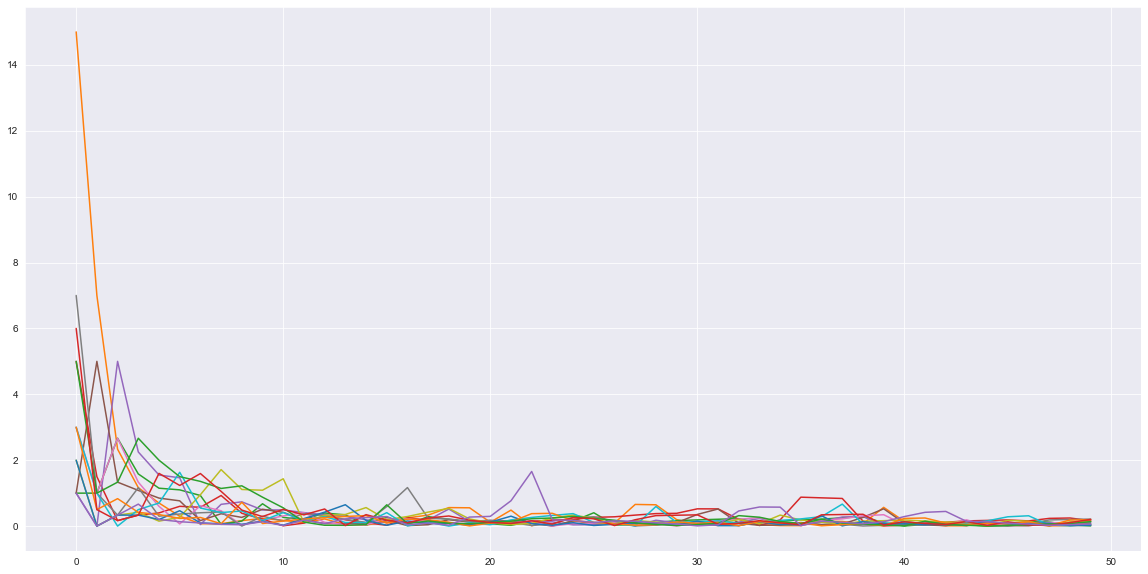

In [32]:
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)
    
#Now repeat the experiment varying gamma

## Thoughts on the MC approach
* we don’t have to compute all the state-values for all the states if we don’t want. We could just focus on a particular grid point and start all the simulations from that initial state to sample episodes that include that state, ignoring all others. This can radically decrease the computational expense.
* This approach does not require a full understanding of the environment dynamics and we can learn directly from experience or simulation.

## Now try to revice the code with "Every visit" MC.

# Temporal Difference Learning
* It merges the best of dynamic programming and the best of Monte Carlo approaches.
* As in the dynamic programming method, here in TD during the optimization of the value function for an initial state, we use the expected values of next state to enrich the prediction. This process is called bootstrapping.
* As in Monte Carlo, we don’t have to have a model of the environment dynamics and can learn directly from experience.
* unlike MC, we don’t have to wait until the end of the episode to start learning. In fact, in the case of TD(0) or one-step TD, we learn at each and every step we take. This particularly is powerful because: on one hand, the nature of learning is truly “online” and on the other hand we can deal with tasks which do not have a clear terminal state, learning and approximating value functions ad infinitum (suitable for non-deterministic non-episodic or time-varying value functions).

# Temporal Difference Learning
![TD](figs/TD-01.png)

## let's implement TD(0): One-step TD

In [33]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%pylab inline
import random

Populating the interactive namespace from numpy and matplotlib


/Users/ashis/venv-DP+MC+TD/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gamma', 'random', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [34]:
# parameters
gamma = 0.6 # discounting rate
rewardSize = -1
gridSize = 4
alpha = 0.1  #stepSize, i.e., learning rate
terminationStates = [[0,0], [gridSize-1, gridSize-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
numIterations = 10000

In [35]:
# initialization
V = np.zeros((gridSize, gridSize))
returns = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
deltas = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]

In [37]:
# utils
def generateInitialState():
    initState = random.choice(states[1:-1])
    return initState

def generateNextAction():
    return random.choice(actions)

def takeAction(state, action):
    if list(state) in terminationStates:
        return 0, None
    finalState = np.array(state)+np.array(action)
    # if robot crosses wall
    if -1 in list(finalState) or gridSize in list(finalState):
        finalState = state
    return rewardSize, list(finalState)

In [39]:
generateInitialState()

[1, 0]

In [40]:
for it in tqdm(range(numIterations)):
    state = generateInitialState()
    while True:
        action = generateNextAction()
        reward, finalState = takeAction(state, action)
        
        # we reached the end
        if finalState is None:
            break
        
        # modify Value function
        before =  V[state[0], state[1]]
        V[state[0], state[1]] += alpha*(reward + gamma*V[finalState[0], finalState[1]] - V[state[0], state[1]])
        deltas[state[0], state[1]].append(float(np.abs(before-V[state[0], state[1]])))
        
        state = finalState

100%|██████████| 10000/10000 [00:02<00:00, 3357.37it/s]


In [41]:
V

array([[ 0.        , -2.09544958, -2.42928953, -2.45917596],
       [-1.71232183, -2.34559631, -2.4268818 , -2.35143469],
       [-2.35982579, -2.43552057, -2.27676294, -2.0973091 ],
       [-2.45674733, -2.42395854, -2.01539662,  0.        ]])

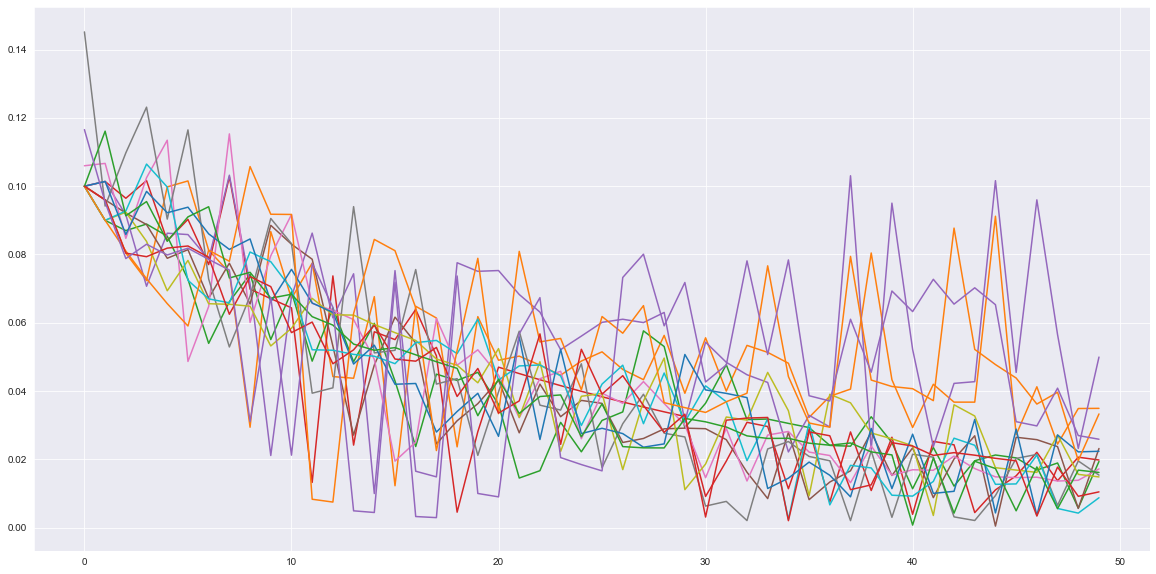

In [42]:
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)
    
#Now try repeating the experiments varying gamma and alpha

## Revise the codes to obtain updated (\*optimum\*) policy
```
Loop forever{
    Policy evaluation
    Policy improvement
}
```